The different code snippets below will be used to generate different graphs and statistics models of the criticality results of all loren frank data.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import cm

def read_mr_estimator_results(result_directory, output_directory = None):
    """made output_directory optional. But highly recommended since integration of all data may take some time

    Args:
        result_directory (str): _description_
        output_directory (_type_, optional): _description_. Defaults to None.

    Returns:
        _type_: _description_
    """
    files = [f for f in os.listdir(result_directory) if f.endswith(".parquet")]

    all_data = []
    for filename in files:
        filename_split = filename.split('_') # with filename pattern being:  "animal name _ experimental day _ task _ tetrode nr. _ brain area _ pre or post treatment _ timechunk .parquet"
        
        df = pd.read_parquet(f'{result_directory}/{filename}')
        df['tau'] = df['tau'][0]
        df['animal'] = filename_split[0]
        df['area'] = filename_split [1]
        df['state'] = filename_split[2]
        df['day'] = filename_split[3]
        df['epoch'] = filename_split[4]
        df['timestamp'] = filename_split[5].split('.')[0]
        all_data.append(df)

    # Combine all data
    df = pd.concat(all_data, ignore_index=True)

    # Convert categorical variables
    df['area'] = df['area'].astype('category')
    df['animal'] = df['animal'].astype('category')
    df['arm'] = df['state'].astype('category')

    if output_directory:
        df.to_parquet(f'{output_directory}big_df.parquet')
    
    return df

def interaction_plot(df, measure):
    plt.figure(figsize=(8,6))

    # Plot mean ± SEM for each area, grouped by state
    sns.pointplot(data=df, x="area", y=measure, hue="state", dodge=True, capsize=0.1, markers="o", errwidth=1, palette="viridis")

    plt.xlabel("Brain Area")
    plt.ylabel(f"Mean {measure} ± SEM")
    plt.title("Interaction Plot: State × Brain Area")
    plt.legend(title="State")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

def grouped_violin_plot(df, measure, smooth = 0.1):
    # Set figure size
    plt.figure(figsize=(8, 6))

    # Create a violin plot
    sns.violinplot(data=df, x="area", y=measure, hue="state", split=True, inner= "box", bw_method=smooth, palette="viridis")

    # Labels and title
    plt.xlabel("Brain Area")
    plt.ylabel(f"{measure} Value")
    plt.title(f"Grouped Violin Plots: {measure} by Brain Area & State")

    # Adjust legend
    plt.legend(title="State")

    # Show grid for readability
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.gca().set_axisbelow(True)

    # Display plot
    plt.show()

def violin_interaction_plot(df, measure, smooth = 0.1):
    # Set figure size
    plt.figure(figsize=(10, 6))

    # Create a new categorical x-axis combining 'area' and 'state'
    df["group"] = df["area"].astype(str) + "-" + df["state"].astype(str)


    # Sort so CA1-run, CA1-sleep, etc., are in the correct order
    df["group"] = pd.Categorical(df["group"], categories=[
        "CA1-run", "CA1-sleep", "CA2-run", "CA2-sleep", "CA3-run", "CA3-sleep"
    ], ordered=True)

    # Create violin plot
    sns.violinplot(data=df, x="group", y= measure, inner="quartile", color="lightgray", bw_method=smooth)

    # Compute means and standard errors
    means = df.groupby("group")[measure].mean()
    sems = df.groupby("group")[measure].sem()

    # Overlay mean points with error bars
    plt.errorbar(x=range(len(means)), y=means, yerr=sems, fmt="o", color="black", capsize=5, label="Mean ± SEM")

    # Extract x-coordinates for connecting lines
    run_indices = [0, 2, 4]  # CA1-run, CA2-run, CA3-run
    sleep_indices = [1, 3, 5]  # CA1-sleep, CA2-sleep, CA3-sleep

    plt.plot(run_indices, means.iloc[run_indices], marker="o", linestyle="-", color= cm.viridis(0.3), label="Run")
    plt.plot(sleep_indices, means.iloc[sleep_indices], marker="o", linestyle="-", color= cm.viridis(0.7), label="Sleep")

    # Labels & legend
    plt.xlabel("Brain Area & State")
    plt.ylabel("Tau Value")
    plt.title("f{measure}: Violin Plot with Mean ± SEM and Interaction Lines")
    plt.xticks(rotation=45)
    plt.legend()
    
    plt.grid(axis="y", linestyle="-", linewidth=0.5, alpha=0.3)
    plt.gca().set_axisbelow(True)
    
    # Show plot
    plt.show()

def density_plot(df, measure, log = False):
    # Set figure size
    plt.figure(figsize=(12, 5))

    # Create separate plots for each state
    states = df["state"].unique()
    for i, state in enumerate(states, 1):
        plt.subplot(1, len(states), i)  # One subplot per state
        
        # Filter data for the current state
        subset = df[df["state"] == state]
        
        # Plot density for each brain area
        sns.kdeplot(data=subset, x=measure, hue="area", common_norm=False, bw_adjust=0.8, fill=True, alpha=0.05, palette="viridis")
        
        # Titles and labels
        plt.title(f"{measure}: Density Plot - {state.capitalize()}")
        plt.xlabel(measure)
        plt.ylabel("Density")
        
        if log:
            plt.xscale("log")
            plt.yscale("log")
            plt.grid(True, which="both", linestyle="--", linewidth=0.5)

    plt.tight_layout()
    plt.show()


generate / load the dataframe. It is recommended to store the df once it is created, since it my tke some minutes.

In [2]:
# df = read_mr_estimator_results('/groups/cns/share/Vincent/loren_frank/mr_analysis_with_new_pipeline/', '/groups/cns/dekorvyb/general_analysis/')
df = pd.read_parquet('/groups/cns/dekorvyb/general_analysis/big_df.parquet') 

Filter df for relevant areas and cut off extreme values

In [3]:
areas_oi = {'CA1', 'CA2', 'CA3'}
df = df[df['area'].isin(areas_oi)]
df['area'] = df['area'].cat.remove_unused_categories()

In [4]:
df = df[df['tau'] <= 3000]

Interaction line plot

/tmp/ipykernel_66922/1659690864.py:51: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(data=df, x="area", y=measure, hue="state", dodge=True, capsize=0.1, markers="o", errwidth=1, palette="viridis")


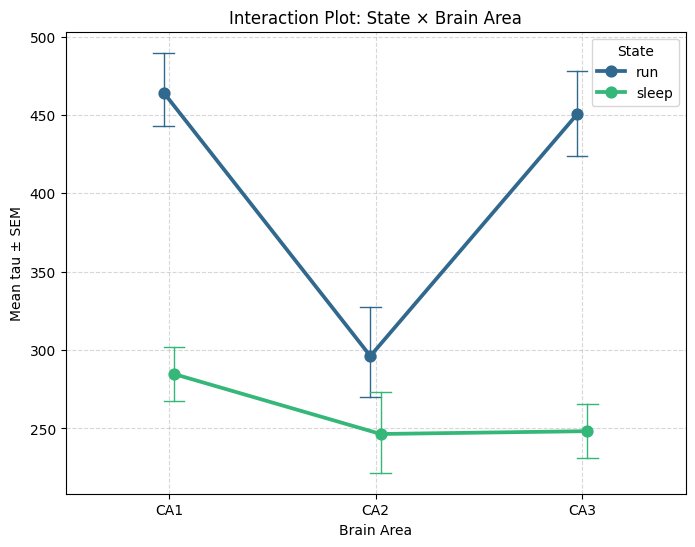

/tmp/ipykernel_66922/1659690864.py:51: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(data=df, x="area", y=measure, hue="state", dodge=True, capsize=0.1, markers="o", errwidth=1, palette="viridis")


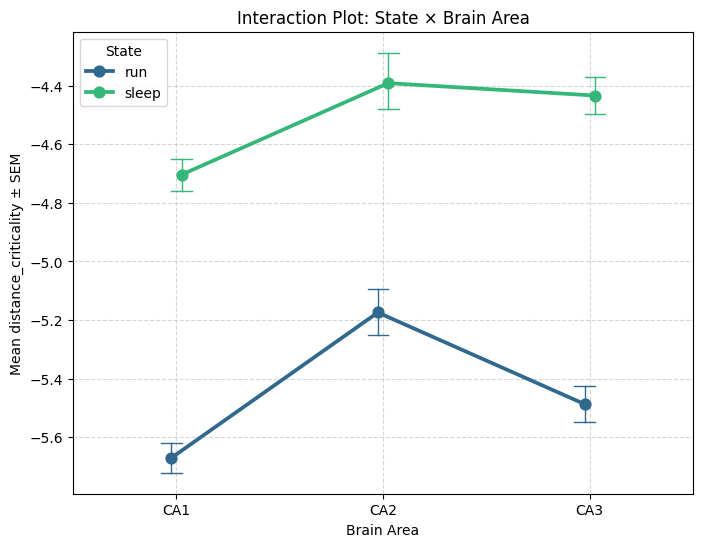

In [16]:
interaction_plot(df, 'tau')
interaction_plot(df, 'distance_criticality')

Grouped violin plot
~ for distance to criticality, it even looks normally distributed! maybe do a test?

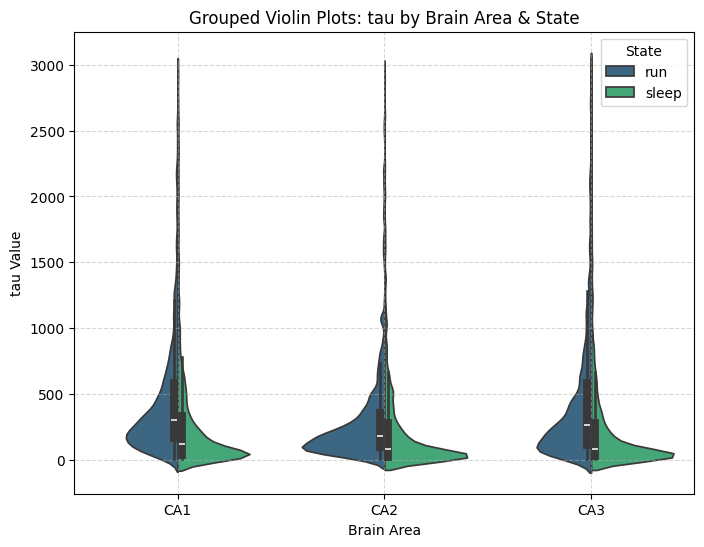

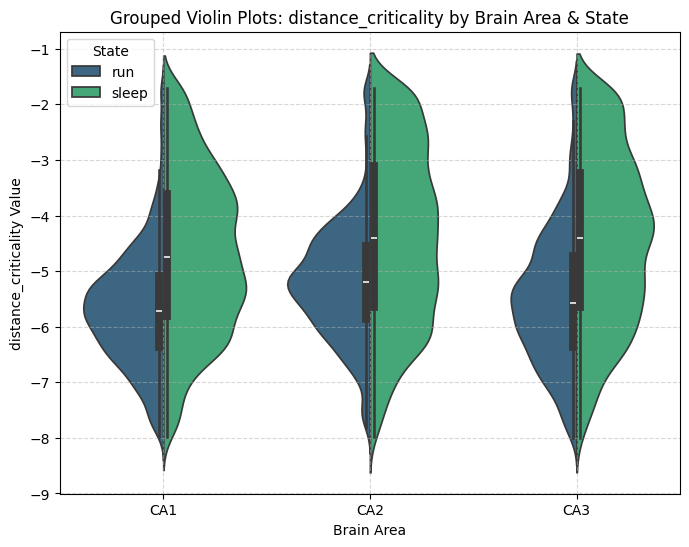

In [ ]:
grouped_violin_plot(df, 'tau', smooth=0.15)
grouped_violin_plot(df, 'distance_criticality', smooth=0.2)

Violin plot & interaction plot combined

/tmp/ipykernel_66922/2139597176.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby("group")[measure].mean()
/tmp/ipykernel_66922/2139597176.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sems = df.groupby("group")[measure].sem()


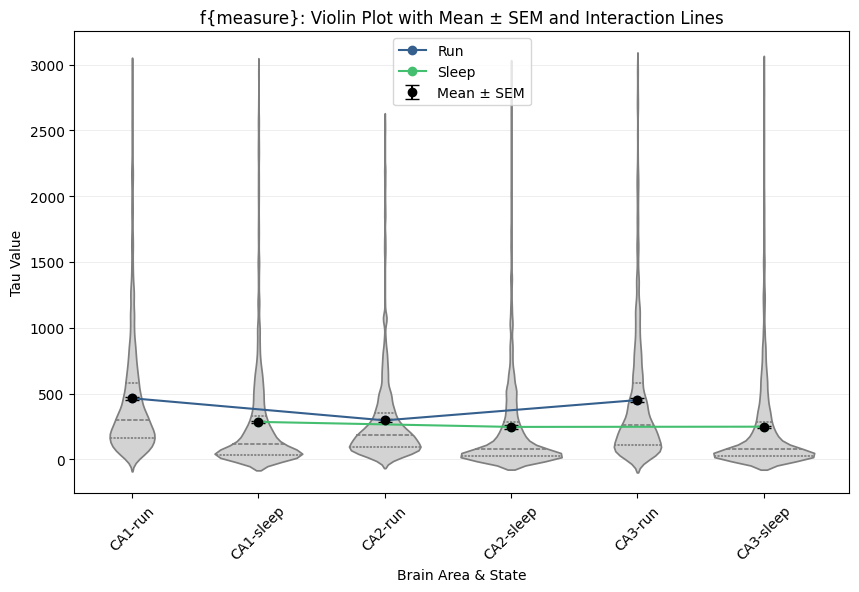

/tmp/ipykernel_66922/2139597176.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby("group")[measure].mean()
/tmp/ipykernel_66922/2139597176.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sems = df.groupby("group")[measure].sem()


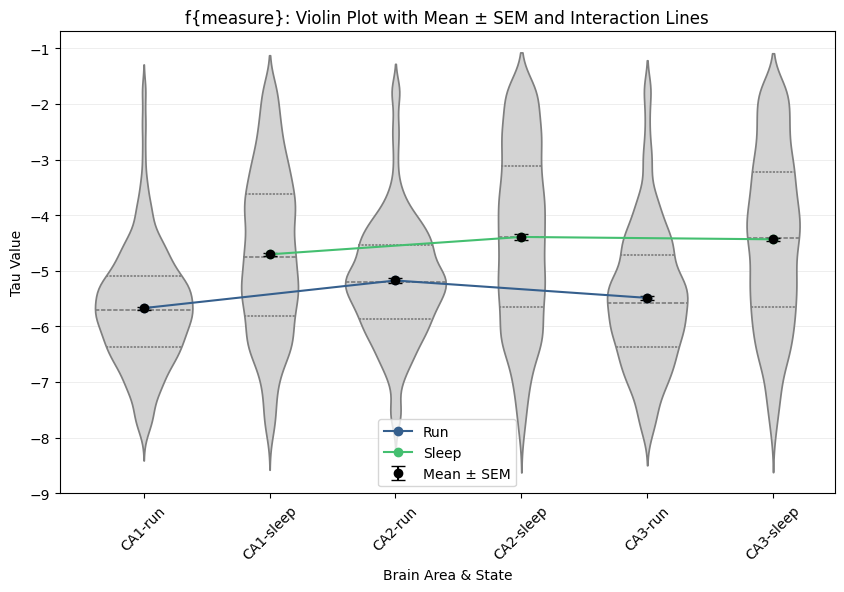

/tmp/ipykernel_66922/2139597176.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby("group")[measure].mean()
/tmp/ipykernel_66922/2139597176.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sems = df.groupby("group")[measure].sem()


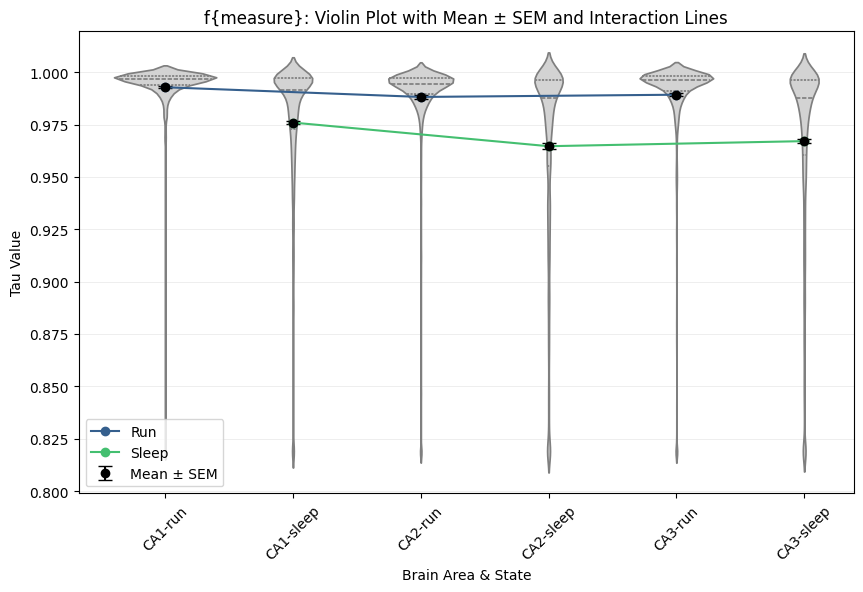

In [6]:
violin_interaction_plot(df, 'tau')
violin_interaction_plot(df, 'distance_criticality', smooth=0.2)
violin_interaction_plot(df, 'branching_factor')

Violin plot & interaction plot, limited on interesting range

/tmp/ipykernel_57996/2238419850.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby("group")["tau"].mean()
/tmp/ipykernel_57996/2238419850.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sems = df.groupby("group")["tau"].sem()


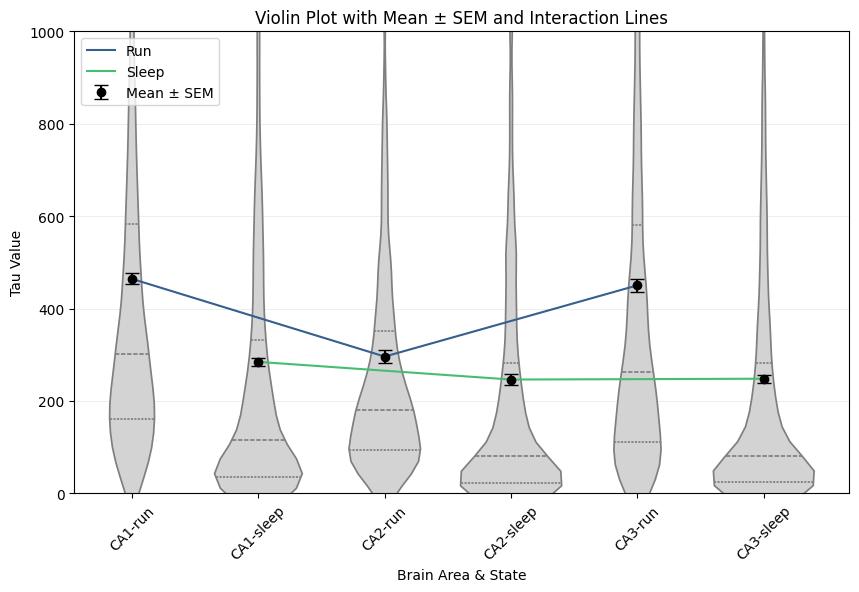

In [32]:
# Set figure size
plt.figure(figsize=(10, 6))


# Create a new categorical x-axis combining 'area' and 'state'
df["group"] = df["area"].astype(str) + "-" + df["state"].astype(str)


# Sort so CA1-run, CA1-sleep, etc., are in the correct order
df["group"] = pd.Categorical(df["group"], categories=[
    "CA1-run", "CA1-sleep", "CA2-run", "CA2-sleep", "CA3-run", "CA3-sleep"
], ordered=True)

# Create violin plot
sns.violinplot(data=df, x="group", y="tau", inner="quartile", color="lightgray", bw_method=0.1)

# Compute means and standard errors
means = df.groupby("group")["tau"].mean()
sems = df.groupby("group")["tau"].sem()

# Overlay mean points with error bars
plt.errorbar(x=range(len(means)), y=means, yerr=sems, fmt="o", color="black", capsize=5, label="Mean ± SEM")

# Extract x-coordinates for connecting lines
run_indices = [0, 2, 4]  # CA1-run, CA2-run, CA3-run
sleep_indices = [1, 3, 5]  # CA1-sleep, CA2-sleep, CA3-sleep

plt.plot(run_indices, means.iloc[run_indices], linestyle="-", color= cm.viridis(0.3), label="Run")
plt.plot(sleep_indices, means.iloc[sleep_indices], linestyle="-", color= cm.viridis(0.7), label="Sleep")

plt.ylim(0, 1000)

# Labels & legend
plt.xlabel("Brain Area & State")
plt.ylabel("Tau Value")
plt.title("Violin Plot with Mean ± SEM and Interaction Lines")
plt.xticks(rotation=45)
plt.legend()
 
plt.grid(axis="y", linestyle="-", linewidth=0.5, alpha=0.3)
plt.gca().set_axisbelow(True)

# Show plot
plt.show()

Create a box plot

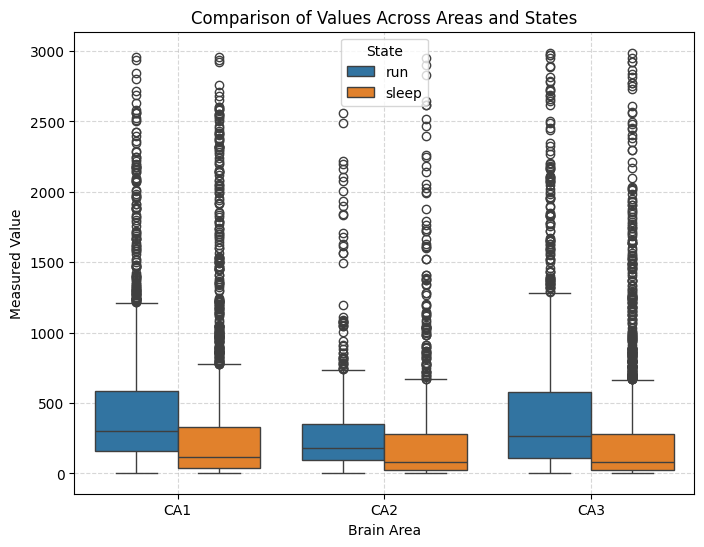

In [17]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="area", y="tau", hue="state")

plt.xlabel("Brain Area")
plt.ylabel("Measured Value")
plt.title("Comparison of Values Across Areas and States")
plt.legend(title="State")
plt.yscale("linear")  # Change to log if needed
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

Density plot

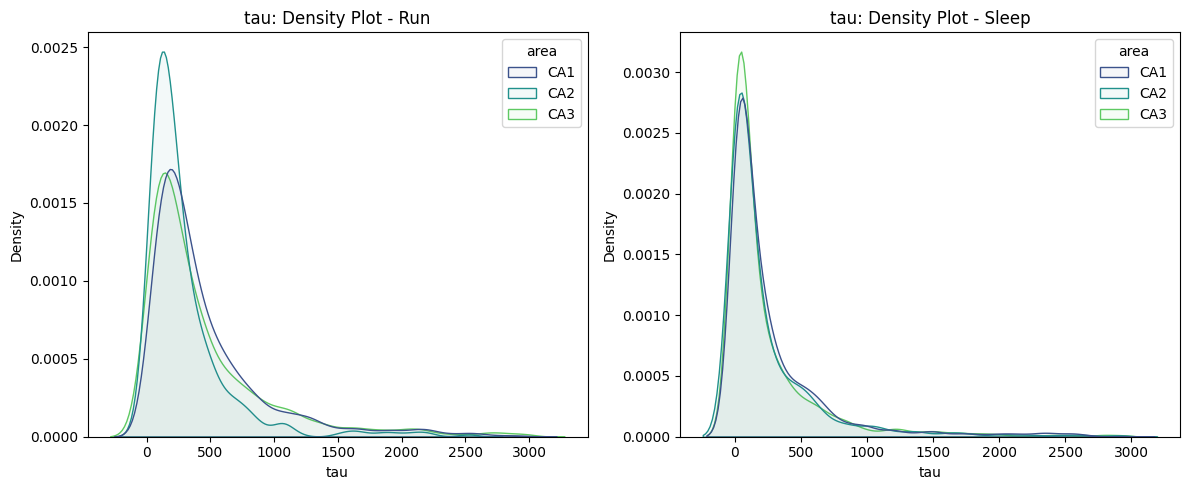

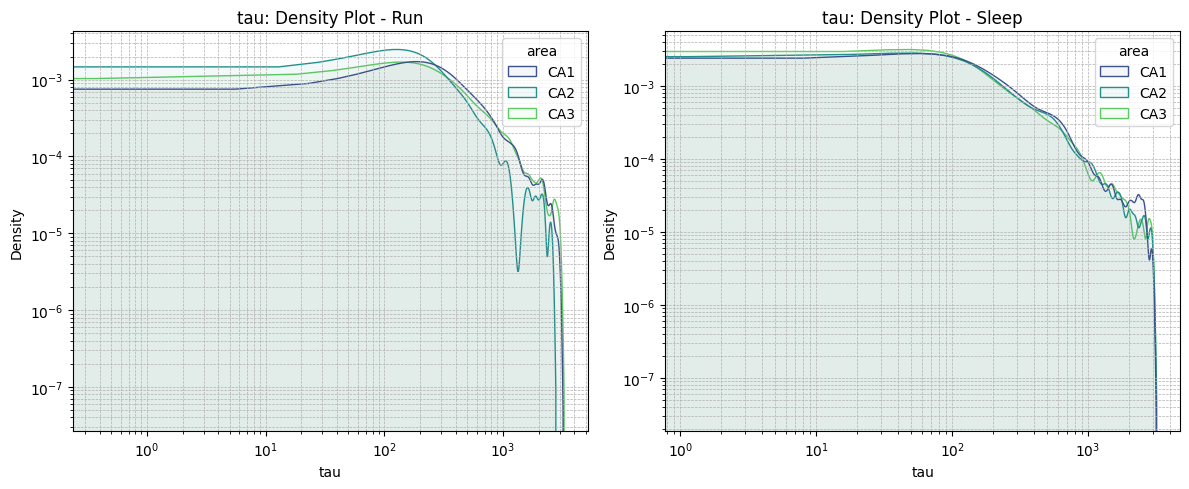

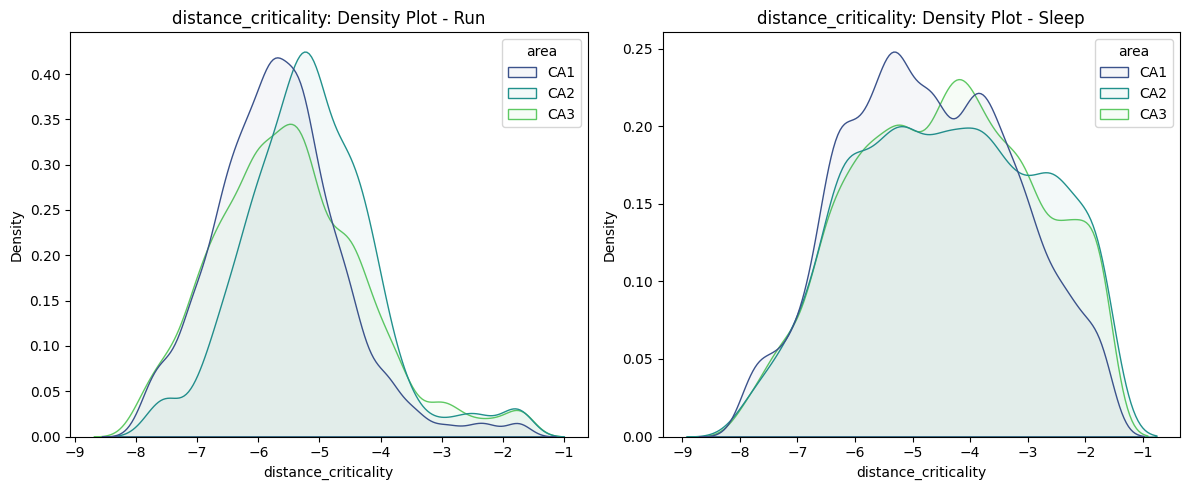

In [14]:
density_plot(df, 'tau')
density_plot(df, 'tau', log = True)
density_plot(df, 'distance_criticality')

Heat map

/tmp/ipykernel_66922/914116551.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df.pivot_table(values="tau", index="state", columns="area", aggfunc=np.mean)
/tmp/ipykernel_66922/914116551.py:1: FutureWarning: The provided callable <function mean at 0x7f6a3259f920> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  heatmap_data = df.pivot_table(values="tau", index="state", columns="area", aggfunc=np.mean)


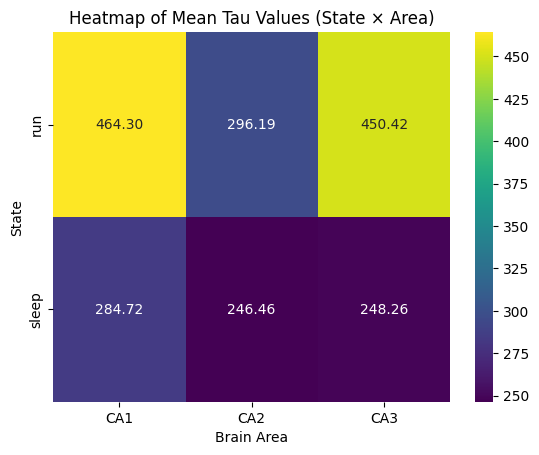

In [9]:
heatmap_data = df.pivot_table(values="tau", index="state", columns="area", aggfunc=np.mean)

sns.heatmap(heatmap_data, annot=True, cmap="viridis", fmt=".2f")

plt.title("Heatmap of Mean Tau Values (State × Area)")
plt.xlabel("Brain Area")
plt.ylabel("State")
plt.show()

Spaghetti plot

/tmp/ipykernel_71522/986299753.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['animal', 'state'])['distance_criticality'].mean().reset_index()


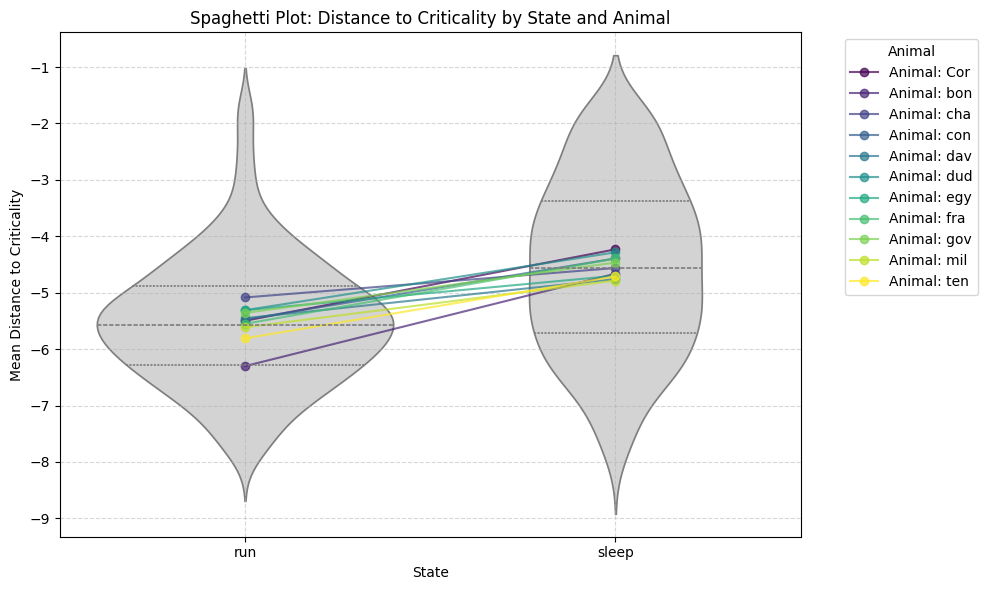

In [8]:
plt.figure(figsize=(10, 6))

# Group by 'animal' and calculate mean values for each state
grouped = df.groupby(['animal', 'state'])['distance_criticality'].mean().reset_index()

# Plot each animal's data
colors = cm.viridis(np.linspace(0, 1, len(grouped['animal'].unique())))
for i, animal in enumerate(grouped['animal'].unique()):
    animal_data = grouped[grouped['animal'] == animal]
    plt.plot(animal_data['state'], animal_data['distance_criticality'], marker='o', label=f'Animal: {animal}', alpha=0.7, color=colors[i])
    
sns.violinplot(data=df, x="state", y= "distance_criticality", inner="quartile", color="lightgray", bw_method=0.3)
# Add labels and title
plt.xlabel("State")
plt.ylabel("Mean Distance to Criticality")
plt.title("Spaghetti Plot: Distance to Criticality by State and Animal")
plt.legend(title="Animal", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle="--", alpha=0.5)

# Show plot
plt.tight_layout()
plt.show()

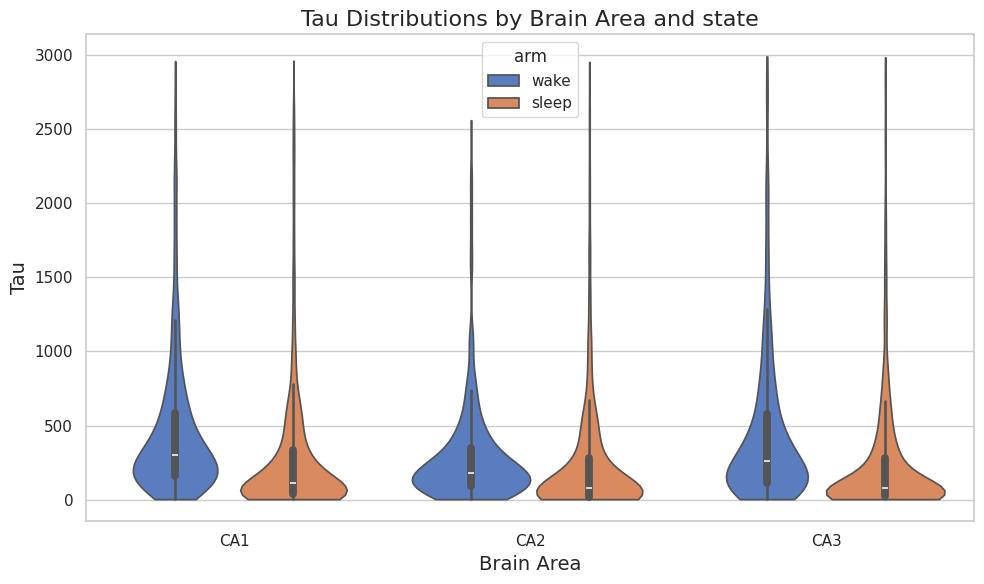

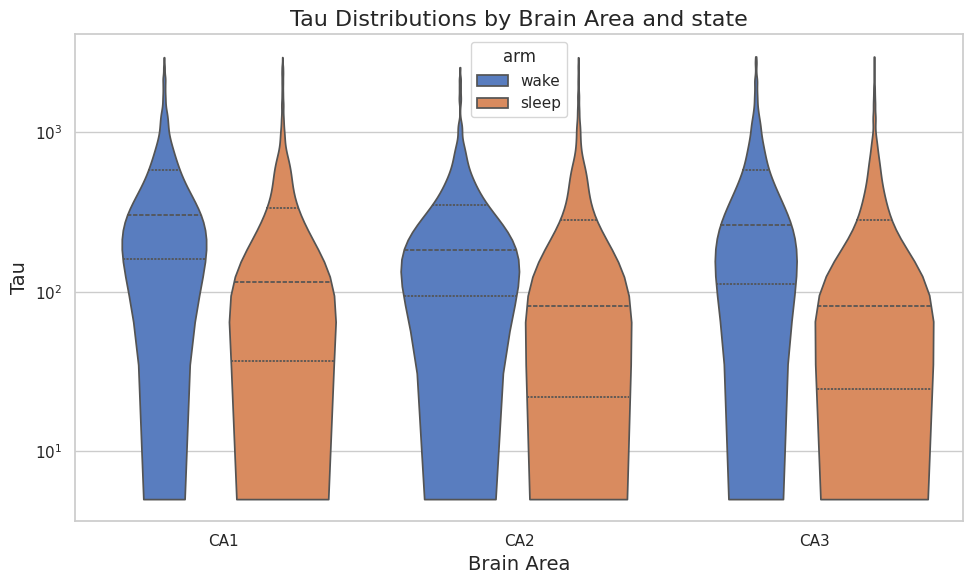

In [ ]:

violin_for_tau(df, hue = 'state', output_directory='/groups/cns/dekorvyb/general_analysis/', add_filename='lf')
violin_for_tau(df, inner = 'quart', hue = 'state', output_directory='/groups/cns/dekorvyb/general_analysis/', add_filename='lf_log', log_scale=True)

Create an interaction graph with error bars

In [ ]:
def tau_interaction_plot(df, output_directory: str = None, add_filename: str = None, log_scale: bool = False):
    # Set plot style
    sns.set(style="whitegrid")
    
    df = df[df['tau'] <= 3000]

    # Create the plot
    plt.figure(figsize=(8, 6))
    ax = sns.pointplot(
        data=df,
        x='area',
        y='tau',
        hue='state',
        capsize=0.2,  # Size of error bars
        dodge=True,  # Offset points slightly to avoid overlap
        markers=["o", "s"],  # Different markers for wake/sleep
        linestyles=["-", "--"],  # Solid and dashed lines for differentiation
        errwidth=1,  # Width of error bars
        palette="muted"  # Use a distinguishable color scheme
    )

    # Add labels and title
    plt.title("Tau Interaction Plot: Area vs. State", fontsize=14)
    plt.xlabel("Brain Area", fontsize=12)
    plt.ylabel("Tau", fontsize=12)
    plt.legend(title="State", fontsize=10)
    
    if log_scale:
        plt.yscale('log')
        
    else:
        ymin, ymax = ax.get_ylim()  # Get current limits
        plt.ylim(ymin * 0.9, ymax * 1.1)

    plt.tight_layout()

    # Save if output directory is provided
    if output_directory:
        filename = f"{output_directory}interaction_tau_{add_filename}.png"
        plt.savefig(filename)

    # Show plot
    plt.show()


/tmp/ipykernel_59001/1186857761.py:9: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  ax = sns.pointplot(


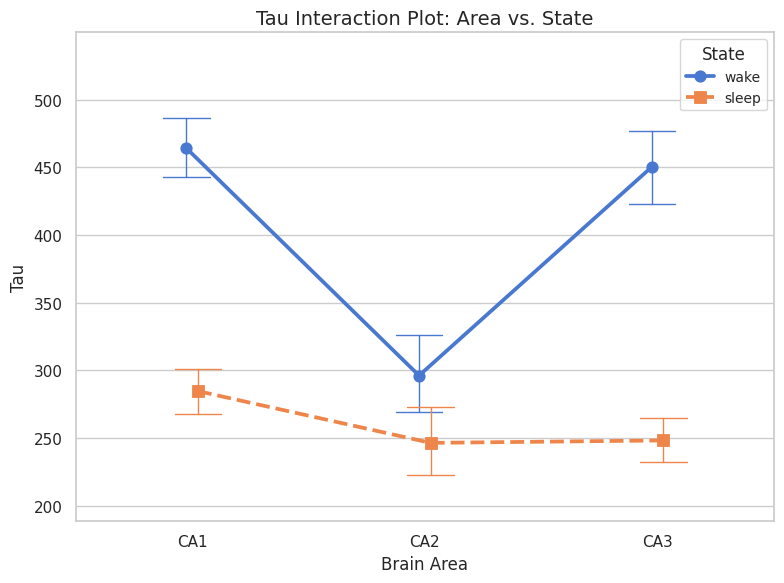

In [ ]:
tau_interaction_plot(df, output_directory='/groups/cns/dekorvyb/general_analysis/', add_filename='lf_wake_sleep')